In [1]:
import wandb
api = wandb.Api()


In [2]:
# Import seaborn
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# group_name = "Sweep delta, seeds, and omit_states_actions with no walls and Q value output (run for longer)."
group_name = "Sweep delta and seeds with Q output and walls."

In [4]:
import pandas as pd
runs = api.runs("rldl/icvi", {"$and": [{"group": group_name}]})

def generate_dfs():
    for run in runs:
        history = pd.DataFrame(run.history())
        if history['_step'].max() < 300_000:
            continue
        history["seed"] = run.config["seed"]
        history["omitted state-action pairs"] = run.config["train_data_args"]["omit_states_actions"]
        history["delta"] = run.config["bellman_delta"]
        yield history

orig = pd.concat(list(generate_dfs()))
orig.columns

Index(['epoch', 'train-n/improved_policy_value', 'test-n/regret',
       'test-n/loss', 'train-n/rmse', 'train-1/loss', '_step',
       'test-1/improved_policy_value', 'train-n/pair_wise_accuracy',
       '_runtime', 'test-1/pair_wise_accuracy', 'test-n/values-plot 48',
       'save_count', 'test-1/values-plot 87', 'test-n/mae', 'test-1/mae',
       'train-1/mae', 'test-n/pair_wise_accuracy', 'fps',
       'test-1/values-plot 48', 'test-1/values-plot 71', 'train-1/rmse',
       '_timestamp', 'test-n/rmse', 'train-1/pair_wise_accuracy',
       'test-n/values-plot 87', 'test-1/regret', 'test-1/rmse', 'train-1/n',
       'lr', 'train-n/regret', 'test-n/improved_policy_value', 'test-1/loss',
       'train-n/mae', 'test-n/values-plot 71', 'seed',
       'omitted state-action pairs', 'delta', 'test-n/values-plot 186',
       'test-1/values-plot 186', 'test-n/values-plot 50',
       'test-1/values-plot 50', 'test-1/values-plot 28',
       'test-n/values-plot 28', 'test-1/values-plot 161',
   

In [5]:
orig.groupby(["seed", "omitted state-action pairs", "delta"])['_step'].max()

seed  omitted state-action pairs  delta
0     0                           1        399000
                                  2        399000
                                  3        399000
                                  100      399000
1     0                           1        399000
                                  2        399000
                                  3        399000
                                  100      399000
2     0                           1        398000
                                  2        398000
                                  3        398000
                                  100      398000
3     0                           1        398000
                                  2        398000
                                  3        398000
                                  100      398000
Name: _step, dtype: int64

In [6]:
df = orig.rename(columns={"_step": "step", "test-n/rmse": "test", "train-1/rmse": "train"})
df = df[(df["delta"] == 1) | (df["delta"] == 100)]
df["delta"] = df["delta"].replace(100, r"$\delta_{\max}$")
df = df[df["step"] <= 400_000]

df = df.melt(id_vars=['step', "delta", "omitted state-action pairs"],  # or any other columns you want to keep unchanged
                    value_vars=['test', 'train'],
                    var_name='regime',
                    value_name='root mean-square error')

df =df.rename(columns={"delta": "$\delta$"})
b = 5000
df['step'] = (df['step'] // b) * b
df.columns

/var/folders/mr/d6vzg_f16dn1wl4_2bcx6l9w0000gn/T/ipykernel_17978/576124756.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["delta"] = df["delta"].replace(100, r"$\delta_{\max}$")


Index(['step', '$\delta$', 'omitted state-action pairs', 'regime',
       'root mean-square error'],
      dtype='object')

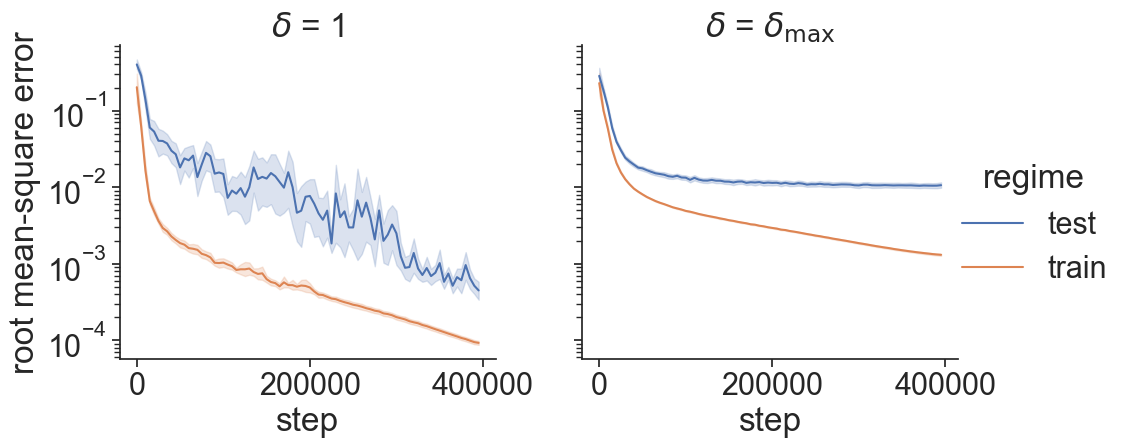

In [7]:
import seaborn as sns
sns.reset_defaults()

sns.set(font_scale=2)
sns.set_style('ticks')


g = sns.relplot(data=df, kind="line", x="step", y="root mean-square error", hue="regime", col="$\delta$")
g.set(yscale="log")
plt.show()

In [8]:
df = orig.rename(columns={"_step": "step", "test-n/regret": "regret"})
df["delta"] = df["delta"].replace(100, r"$\delta_{\max}$")
df = df[df["step"] <= 400_000]
df.loc[:, 'regret'] = df['regret'].clip(lower=1e-6)

window = 10
def calculate_stats(group):
    mean = group['regret'].rolling(window=window).mean()
    std = group['regret'].rolling(window=window).std()
    group['regret'] = mean
    group['upper'] = (mean + std).clip(lower=1e-6)
    group['lower'] = (mean - std).clip(lower=1e-6)
    return group

b = 5000
df.loc[:, 'step'] = (df['step'] // b) * b
df =df.rename(columns={"delta": "$\delta$", "regret": "regret of improved policy"})

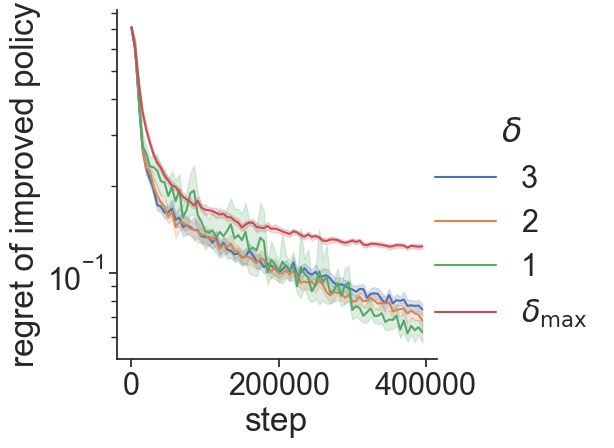

In [9]:
import seaborn as sns

sns.reset_defaults()
sns.set(font_scale=2)
sns.set_style('ticks')

g = sns.relplot(data=df, kind="line", x="step", y="regret of improved policy", hue="$\delta$")
g.set(yscale="log")
plt.show()